# Tensorflow - Pneumonia detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [9]:
# Test his environment
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Preprocess images

Due to the poor size of validation dataset (~10), we moved validation dataset to the training dataset and we will pick ~10-20% of the training dataset as validation data


- For data augmentation images, check more_data notebook

Training size:
- NORMAL: 1341 * 2 = 2682
- PNEUMONIA: 3875 *2 = 7750
Total = 10468

test size: 640




In [2]:
# Define the paths to the training and test directories
train_data_dir = '../data/chest_Xray/train'
test_data_dir = '../data/chest_Xray/test'

# Define the path to the directory containing the augmented images
aug_data_dir = '../data/chest_Xray/train_augmented'
 

# Image size and batch size
img_height, img_width = 180, 180
batch_size = 32

# load and preprocess the dataset and store them in a batch (32 images per 32)
print('TRAINING_DS:')
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="both",
    color_mode="grayscale",
    seed=0,
)

# load class_names
class_names = train_ds.class_names
num_classes = len(class_names)


# Load augmented data
print('TRAINING_AUGMENTED_DS:')
train_aug_ds, val_aug_ds = tf.keras.utils.image_dataset_from_directory(
    aug_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",
    validation_split=0.2,
    subset="both",
    seed=0,
)

print('TEST_DS:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",
    seed=0,
)


# merge augmented data with real_data
train_ds = train_ds.concatenate(train_aug_ds)
val_ds = val_ds.concatenate(val_aug_ds)

TRAINING_DS:
Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Using 1043 files for validation.
TRAINING_AUGMENTED_DS:
Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Using 1043 files for validation.
TEST_DS:
Found 640 files belonging to 2 classes.


In [43]:
# Get informations of our datasets
print("DATASETS:")
print(train_ds)
print(val_ds)
print(test_ds)
print(class_names)
print("Number of elements in the training_dataset:", train_ds.cardinality().numpy() * batch_size)
print("Number of elements in the validation_dataset:", val_ds.cardinality().numpy() * batch_size)
print("Number of elements in the test_dataset:", test_ds.cardinality().numpy() * batch_size)

DATASETS:
<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
['NORMAL', 'PNEUMONIA']
Number of elements in the training_dataset: 8384
Number of elements in the validation_dataset: 2112
Number of elements in the test_dataset: 640


shape != (32, 180, 180, 1) because some batches are incomplete, you can check with that:
We have 2 of 13 batch_size and the rest of 32

It is better to have batches of the same size, it is not always possible or practical, and having a few batches of a different size is generally acceptable. However, if you have a large number of batches with very different sizes, you may want to consider adjusting the batch size or resampling the data to achieve more uniform batch sizes.

In [41]:
for batch in train_ds:
    inputs, labels = batch
    print(tf.shape(inputs))

tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1], shape=(4,), dtype=int32)
tf.Tensor([ 32 180 180   1],

## Visualize our data

With the library matplotlib, we can visualize our dataset

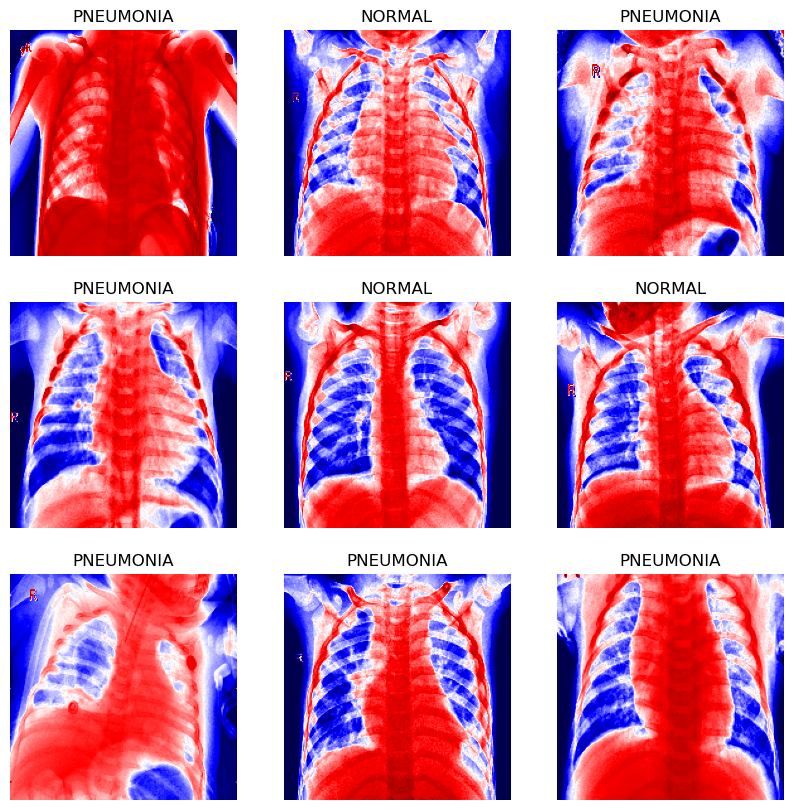

In [44]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="seismic") # cmap works only with grayscale
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [45]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 1)
(32,)


# Model
## Multi-Layer Perceptron (MLP)

This kind of model is called a Multi-Layer Perceptron (MLP). While it can be used for image classification tasks, it is generally less effective than CNNs because it does not exploit the spatial structure and local patterns in images. Moreover, MLPs typically require more parameters and are more prone to overfitting compared to CNNs, especially when dealing with larger images.

### How to choose the end activation fonction?

For classification tasks, the two most common activation functions are softmax and sigmoid.

- `Softmax`: The softmax activation function is used for multi-class classification problems where each input can belong to one of multiple classes. It calculates the probabilities for each class, and the probabilities sum to 1. It is the recommended activation function for multi-class classification tasks.

- `Sigmoid`: The sigmoid activation function is typically used for binary classification problems, where each input can belong to one of two classes. The sigmoid function outputs a probability value between 0 and 1, representing the likelihood of an input belonging to the positive class. It is the recommended activation function for binary classification tasks.

Using the correct activation function for your specific problem will generally result in better model performance.



In [5]:
num_classes = len(train_ds.class_names) # 2 ["NORMAL", "PNEUMONIA"]

In [34]:
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
# view all the layers of the network
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 flatten_4 (Flatten)         (None, 32400)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               4147328   
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4,147,586
Trainable params: 4,147,586
Non-trainable params: 0
_________________________________________________________________


In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
147/147 [==============================] - 6s 35ms/step - loss: 1.1162 - accuracy: 0.8552 - val_loss: 0.5164 - val_accuracy: 0.8772
Epoch 2/100
147/147 [==============================] - 5s 35ms/step - loss: 0.2717 - accuracy: 0.9261 - val_loss: 0.1995 - val_accuracy: 0.9405
Epoch 3/100
147/147 [==============================] - 5s 34ms/step - loss: 0.2789 - accuracy: 0.9276 - val_loss: 0.4979 - val_accuracy: 0.9002
Epoch 4/100
147/147 [==============================] - 5s 34ms/step - loss: 0.2310 - accuracy: 0.9408 - val_loss: 0.4466 - val_accuracy: 0.8925
Epoch 5/100
147/147 [==============================] - 5s 33ms/step - loss: 0.3882 - accuracy: 0.9174 - val_loss: 0.2095 - val_accuracy: 0.9539
Epoch 6/100
147/147 [==============================] - 5s 33ms/step - loss: 0.2881 - accuracy: 0.9316 - val_loss: 0.1220 - val_accuracy: 0.9635
Epoch 7/100
147/147 [==============================] - 5s 31ms/step - loss: 0.2790 - accuracy: 0.9355 - val_loss: 0.2122 - val_accuracy:

In [45]:
# visualize training results
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


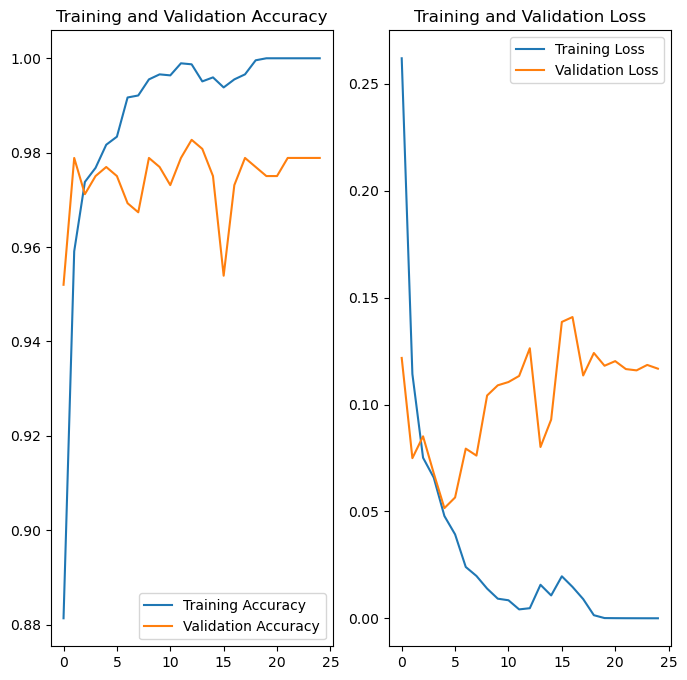

In [46]:
visualize(history)

In [47]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 42ms/step - loss: 0.8341 - accuracy: 0.7922
Test accuracy: 0.792187511920929


In [39]:
#save model
model.save("./tf_models/MLP", include_optimizer=False)

INFO:tensorflow:Assets written to: ./tf_models/MLP\assets


## CNN

![cnn](./images/a-cnn-sequence-to-classify-handwritten-digits.jpg)

1. `layers.Conv2D`: This is a convolutional layer that performs 2D convolution on the input data. The main utility of this layer is to detect local features or patterns (such as edges, corners, and textures) in the input image. The parameters of this layer are:
    - `16`: The number of filters (or kernels) to be used in the convolution operation. This determines the number of feature maps that the layer will output.

    - `(3, 3)`: The size of the filters (or kernels) used for the convolution. In this case, each filter is a 3x3 matrix. Smaller filter sizes are typically used to capture fine-grained features, while larger filter sizes capture more abstract or global features.

    - `activation='relu'`: The activation function applied to the output of the convolution operation. The Rectified Linear Unit (ReLU) activation function is commonly used in CNNs due to its ability to introduce non-linearity, speed up training, and mitigate the vanishing gradient problem.

2. `layers.MaxPooling2D`: This is a pooling layer that performs 2D max pooling on the input data. The main utility of this layer is to reduce the spatial dimensions (height and width) of the input feature maps, which helps to:

    - Reduce the number of parameters in the network, making it computationally more efficient and less prone to overfitting.

    - Enhance the network's ability to capture more abstract features, as the pooling operation aggregates information from adjacent pixels.

    - Improve the network's translation invariance, as the pooling operation makes the network less sensitive to small translations in the input image.

In summary, the combination of the `Conv2D` layer and the `MaxPooling2D` layer allows the CNN to learn and extract hierarchical features from the input image while reducing the overall complexity of the network.


In [13]:
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),

    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 64)       

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
147/147 [==============================] - 15s 60ms/step - loss: 0.2372 - accuracy: 0.9012 - val_loss: 0.1470 - val_accuracy: 0.9463
Epoch 2/100
147/147 [==============================] - 5s 31ms/step - loss: 0.1104 - accuracy: 0.9591 - val_loss: 0.0911 - val_accuracy: 0.9655
Epoch 3/100
147/147 [==============================] - 4s 28ms/step - loss: 0.0878 - accuracy: 0.9670 - val_loss: 0.0557 - val_accuracy: 0.9866
Epoch 4/100
147/147 [==============================] - 4s 29ms/step - loss: 0.0768 - accuracy: 0.9734 - val_loss: 0.0662 - val_accuracy: 0.9827
Epoch 5/100
147/147 [==============================] - 4s 28ms/step - loss: 0.0496 - accuracy: 0.9808 - val_loss: 0.0530 - val_accuracy: 0.9846
Epoch 6/100
147/147 [==============================] - 4s 28ms/step - loss: 0.0451 - accuracy: 0.9832 - val_loss: 0.0937 - val_accuracy: 0.9693
Epoch 7/100
147/147 [==============================] - 4s 29ms/step - loss: 0.0374 - accuracy: 0.9845 - val_loss: 0.0795 - val_accuracy

KeyboardInterrupt: 

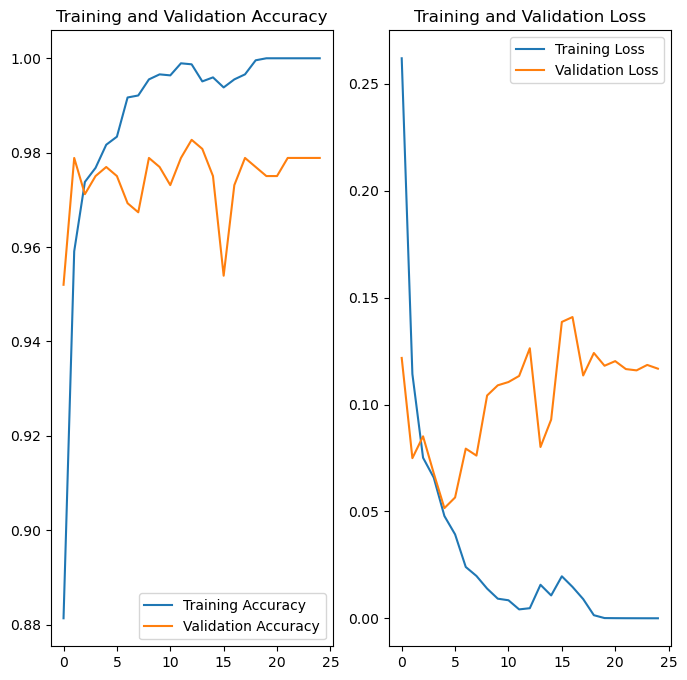

In [48]:
visualize(history)

In [49]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 8s 413ms/step - loss: 0.8341 - accuracy: 0.7922
Test accuracy: 0.792187511920929


In [50]:
#save model
model.save("./tf_models/CNN", include_optimizer=False)

INFO:tensorflow:Assets written to: ./tf_models/CNN\assets


INFO:tensorflow:Assets written to: ./tf_models/CNN\assets


## Optimisation: Data augmentation

- You can generates the augmented images with the script of data_augmentation.ipynb

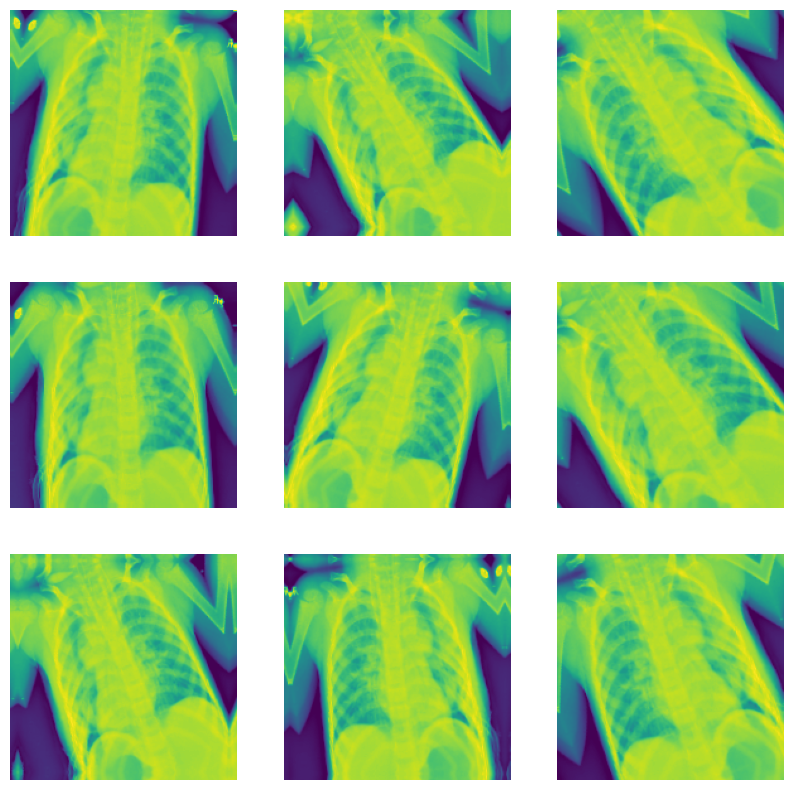

In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# visualize
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [50]:
from keras import Input

model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 1)),
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

NameError: name 'data_augmentation' is not defined

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
147/147 [==============================] - 26s 173ms/step - loss: 0.3556 - accuracy: 0.8443 - val_loss: 0.5714 - val_accuracy: 0.7831
Epoch 2/100
147/147 [==============================] - 26s 176ms/step - loss: 0.2495 - accuracy: 0.9001 - val_loss: 0.2716 - val_accuracy: 0.8829
Epoch 3/100
147/147 [==============================] - 27s 182ms/step - loss: 0.2012 - accuracy: 0.9165 - val_loss: 0.2813 - val_accuracy: 0.8829
Epoch 4/100
147/147 [==============================] - 27s 182ms/step - loss: 0.1700 - accuracy: 0.9327 - val_loss: 0.2620 - val_accuracy: 0.8983
Epoch 5/100
147/147 [==============================] - 27s 181ms/step - loss: 0.1576 - accuracy: 0.9372 - val_loss: 0.3782 - val_accuracy: 0.8868
Epoch 6/100
147/147 [==============================] - 28s 191ms/step - loss: 0.1358 - accuracy: 0.9476 - val_loss: 0.2314 - val_accuracy: 0.9136
Epoch 7/100
147/147 [==============================] - 28s 186ms/step - loss: 0.1453 - accuracy: 0.9453 - val_loss: 0.2619 -

In [20]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 36ms/step - loss: 0.8990 - accuracy: 0.8125
Test accuracy: 0.8125


In [21]:
model.save("./tf_models/CNN_AUGMENTATION_DROPOUT", include_optimizer=False)

### test with bigger conv2d filter 

83%

In [57]:
from keras import Input

model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 1)),
    #data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


# prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
    verbose=1,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
262/262 [==============================] - 10s 34ms/step - loss: 0.4022 - accuracy: 0.7991 - val_loss: 0.2433 - val_accuracy: 0.8969
Epoch 2/100
262/262 [==============================] - 9s 33ms/step - loss: 0.2211 - accuracy: 0.9070 - val_loss: 0.2039 - val_accuracy: 0.9123
Epoch 3/100
262/262 [==============================] - 9s 33ms/step - loss: 0.1721 - accuracy: 0.9281 - val_loss: 0.1855 - val_accuracy: 0.9238
Epoch 4/100
262/262 [==============================] - 9s 34ms/step - loss: 0.1480 - accuracy: 0.9395 - val_loss: 0.1815 - val_accuracy: 0.9319
Epoch 5/100
262/262 [==============================] - 9s 33ms/step - loss: 0.1183 - accuracy: 0.9502 - val_loss: 0.2366 - val_accuracy: 0.9060
Epoch 6/100
262/262 [==============================] - 9s 33ms/step - loss: 0.0896 - accuracy: 0.9653 - val_loss: 0.1791 - val_accuracy: 0.9396
Epoch 7/100
262/262 [==============================] - 9s 33ms/step - loss: 0.0737 - accuracy: 0.9726 - val_loss: 0.1890 - val_accuracy

In [59]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 26ms/step - loss: 0.5708 - accuracy: 0.8328
Test accuracy: 0.832812488079071


In [11]:
model.save("./tf_models/85%", include_optimizer=False)

### Recherche Optimisation

In [60]:
from keras import Input

model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 1)),
    layers.Rescaling(1./255),
    
    layers.Conv2D(32, (3, 3)),
    layers.BatchNormalization(), # help improve the training speed and model performance by reducing the internal covariate shift.
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(), # help reduce the number of parameters in the model and make it less prone to overfitting.
    layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


# prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many consecutive epochs don't improve to wait before stopping
    restore_best_weights=True, # delete if overfitting ( usually the lowest validation loss or highest validation accuracy)
    verbose=1,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
262/262 [==============================] - 15s 52ms/step - loss: 0.3856 - accuracy: 0.8585 - val_loss: 2.9794 - val_accuracy: 0.7498
Epoch 2/100
262/262 [==============================] - 14s 51ms/step - loss: 0.3239 - accuracy: 0.8898 - val_loss: 0.4632 - val_accuracy: 0.8351
Epoch 3/100
262/262 [==============================] - 14s 51ms/step - loss: 0.3017 - accuracy: 0.8952 - val_loss: 4.3208 - val_accuracy: 0.2507
Epoch 4/100
262/262 [==============================] - 14s 52ms/step - loss: 0.2850 - accuracy: 0.8943 - val_loss: 1.2203 - val_accuracy: 0.3082
Epoch 5/100
262/262 [==============================] - 14s 51ms/step - loss: 0.2665 - accuracy: 0.9026 - val_loss: 1.4022 - val_accuracy: 0.3217
Epoch 6/100
262/262 [==============================] - 14s 51ms/step - loss: 0.2641 - accuracy: 0.9040 - val_loss: 2.3688 - val_accuracy: 0.2699
Epoch 7/100
262/262 [==============================] - 13s 51ms/step - loss: 0.2634 - accuracy: 0.8984 - val_loss: 1.7661 - val_ac

In [62]:
# Test model with test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 27ms/step - loss: 0.5540 - accuracy: 0.7437
Test accuracy: 0.7437499761581421


In summary too much layers is not the ideal to optimize the model

## Optimize the model
The best model we got is the CNN with 64, 128, 256 layers but to faciliate, we can try to optimize this model by finding best parameter of the layers

In general, tuning the MaxPooling2D layers is not as crucial as tuning other hyperparameters like the number of filters, kernel size, or learning rate. MaxPooling2D layers are used to reduce the spatial dimensions of the feature maps and provide a form of translation invariance to the model. The most common pooling size used is (2, 2), which reduces the spatial dimensions by a factor of 2.

Random Search, Hyperband, and Bayesian Optimization are three different hyperparameter optimization methods used in machine learning to find the best model architecture and parameters.

- Random Search: Random Search is a simple and widely used method for hyperparameter optimization. In this method, hyperparameter combinations are sampled randomly from a predefined search space. The model is then trained and evaluated with each combination, and the best-performing combination is chosen. Random Search is computationally inexpensive but may require a large number of trials to find a good set of hyperparameters, especially in high-dimensional search spaces.

- Hyperband: Hyperband is an optimization method based on random search but with adaptive resource allocation and early stopping. It focuses on finding the best model with a limited budget of resources (like training time). The key idea behind Hyperband is to allocate more resources to the more promising models and stop training the less promising ones early. This is achieved by training models for varying numbers of epochs and adaptively allocating resources based on their performance. Hyperband is more efficient than Random Search as it can explore the search space more effectively by leveraging early stopping.

- Bayesian Optimization: Bayesian Optimization is a more advanced and efficient method for hyperparameter optimization. It uses a probabilistic model (usually a Gaussian Process) to model the objective function, which maps hyperparameter combinations to model performance. Based on the performance of previously evaluated models, it selects the next set of hyperparameters to try by optimizing an acquisition function that balances exploration (trying new hyperparameter combinations) and exploitation (focusing on known good combinations). Bayesian Optimization is more efficient than Random Search, as it uses prior knowledge about the performance of previous models to make informed decisions about which hyperparameter combinations to try next.


In summary, Random Search is the simplest method but may require more trials to find good hyperparameters. Hyperband improves upon Random Search by adaptively allocating resources and using early stopping, making it more efficient in finding good models within a limited budget. Bayesian Optimization is the most advanced method, using a probabilistic model to guide the search for optimal hyperparameters, often resulting in better model performance in fewer trials.

In [3]:
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
import copy

def build_model(hp):
    model = tf.keras.Sequential([
        layers.Input(shape=(img_height, img_width, 1)),
        layers.Rescaling(1./255),
        
        layers.Conv2D(
            filters=hp.Int("conv_1_filter", min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice("conv_1_kernel", values=[3, 5]),
            activation="relu"
        ),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(
            filters=hp.Int("conv_2_filter", min_value=32, max_value=256, step=16),
            kernel_size=hp.Choice("conv_2_kernel", values=[3, 5]),
            activation="relu"
        ),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(
            filters=hp.Int("conv_3_filter", min_value=32, max_value=256, step=16),
            kernel_size=hp.Choice("conv_3_kernel", values=[3, 5]),
            activation="relu"
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=hp.Int("dense_units", min_value=32, max_value=128, step=16),
            activation="relu"
        ),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [4]:
from keras.callbacks import EarlyStopping

def create_early_stopping_callback():
    return EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.001,
        restore_best_weights=True
    )

In [6]:
# Initialize the Keras Tuner and set up the search space:
# tuner = RandomSearch(
#     build_model,
#     objective="val_accuracy",
#     max_trials=10,
#     executions_per_trial=3,
#     directory="output",
#     project_name="KerasTunerCNN"
# )

#Initialize the Keras Tuner and set up the search space:
tuner = BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=3,
    directory="output",
    project_name="KerasTunerCNN"
)


# find the best parameters
tuner.search(train_ds,
             epochs=100, # You can increase the maximum number of epochs since early stopping will halt training when there is no improvement
             callbacks=[create_early_stopping_callback()],
             validation_data=val_ds,
             steps_per_epoch=len(train_ds),
             validation_steps=len(val_ds))

Trial 20 Complete [00h 13m 58s]
val_accuracy: 0.9576541980107626

Best val_accuracy So Far: 0.9576541980107626
Total elapsed time: 04h 16m 43s
INFO:tensorflow:Oracle triggered exit


In [7]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(best_hyperparameters.values)

Best hyperparameters:
{'conv_1_filter': 32, 'conv_1_kernel': 3, 'conv_2_filter': 176, 'conv_2_kernel': 5, 'conv_3_filter': 176, 'conv_3_kernel': 5, 'dense_units': 96, 'learning_rate': 0.00011451155720572537}


In [8]:
# Test model with test dataset
loss, accuracy = best_model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

20/20 [==============================] - 1s 31ms/step - loss: 0.9683 - accuracy: 0.8188
Test accuracy: 0.8187500238418579


In [9]:
best_model.save("./tf_models/cnn_keras_tuner_81%")

INFO:tensorflow:Assets written to: ./tf_models/cnn_keras_tuner_81%\assets


INFO:tensorflow:Assets written to: ./tf_models/cnn_keras_tuner_81%\assets


----------------
### Plot performance
- Analysons Notre meilleur modèle à 85%:




In [8]:
from keras.models import load_model
best_model = load_model('./tf_models/85%')

# architecture
best_model.summary()
print(type(best_model))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 1)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

In [ ]:
# Evaluate the restored model
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy}")

print(new_model.predict(test_ds).shape)
